# Libs

In [1]:
import pandas as pd
import numpy as np

In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar, Holiday
from pandas import Timestamp

In [3]:
from workalendar.usa import UnitedStates

In [4]:
from tqdm import tqdm

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [6]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [7]:
import cpi

In [8]:
from geopy.distance import geodesic

In [9]:
tqdm.pandas()

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from catboost import CatBoostRegressor

In [12]:
from sklearn.cluster import KMeans

# Useful funtions

In [13]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype.name
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [14]:
from math import radians, cos, sin, asin, sqrt

# Формула для расчета расстояния между двумя точками (м)

def geodistance(lng1, lng2, lat1, lat2):
    lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)]) # долгота и широта конвертируются в радианы
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2 
    distance = 2 * asin (sqrt(a)) * 6371 * 1000 # Средний радиус Земли, 6371 км
    distance = round(distance / 1000, 3)
    return distance

# Data preprocessing

In [15]:
LEFT_LOWER_BOUND = (-75, 40)
RIGHT_UPPE_BOUND = (-72, 42)
CENTER = (40.7, -73.8)

In [16]:
# for x in pd.read_csv("data/train.csv", chunksize=5_000_000):
#     data = x
#     break

data = pd.read_csv("data/train.csv")
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [17]:
df = data.copy().iloc[::(55_423_856 // 5_000_000)]# .sample(5_000_000)

In [18]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
11,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00 UTC,0.000000,0.000000,0.000000,0.000000,3
22,2009-08-06 18:17:23.0000001,4.5,2009-08-06 18:17:23 UTC,-73.991707,40.770505,-73.985459,40.763671,1
33,2011-09-07 14:05:00.000000194,5.7,2011-09-07 14:05:00 UTC,-73.976162,40.744988,-73.990002,40.738323,2
44,2011-03-04 18:12:00.000000250,5.3,2011-03-04 18:12:00 UTC,-73.997037,40.737095,-73.986128,40.735043,1


In [19]:
df = df.dropna()

## date preprocessing

In [20]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2009-01-01', end='2016-01-01')
holidays = list(holidays.date)

years = range(2009, 2016)
weekends = []

for year in years:
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year}-12-31')
    all_dates = pd.date_range(start=start_date, end=end_date)

    weekends.extend([date.date() for date in all_dates if date.weekday() >= 5])

In [21]:
years = [i for i in range(2009, 2016)]
inflation = dict.fromkeys(years, 0)

for key in inflation.keys():
    inflation[key] = round(cpi.inflate(1000, key, to=2009) / 1000, 3)

## coordinates preprocessing

### clustering

In [22]:
coords = df[['pickup_latitude', 'pickup_longitude']]
kmeans_pick = KMeans(n_clusters=10, random_state=0).fit(coords)

In [23]:
coords = df[['dropoff_latitude', 'dropoff_longitude']]
kmeans_drop = KMeans(n_clusters=10, random_state=0).fit(coords)

### water points removing

100%|██████████| 10000/10000 [00:04<00:00, 2129.22it/s]


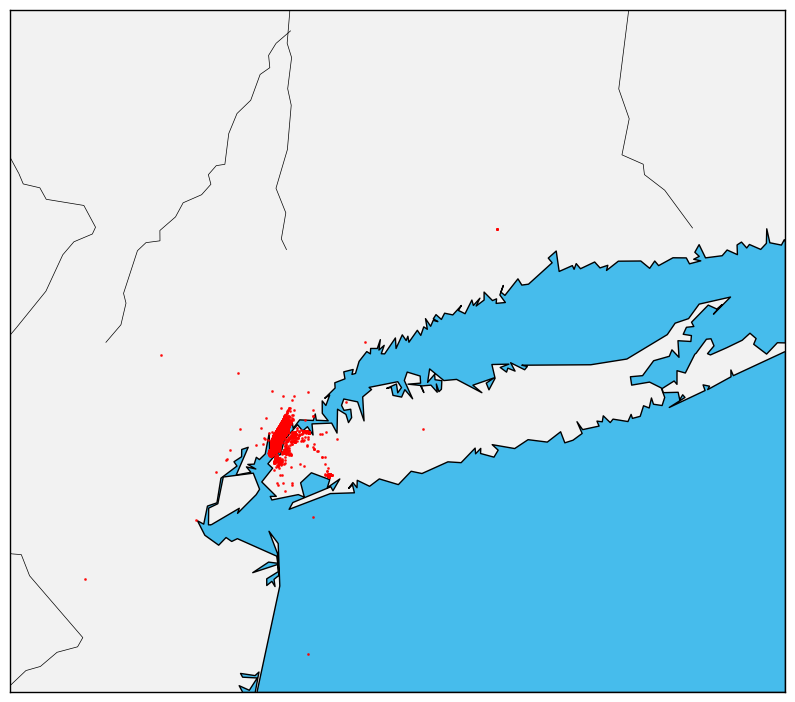

In [24]:
# Создаем карту
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=LEFT_LOWER_BOUND[0], llcrnrlat=LEFT_LOWER_BOUND[1],
            urcrnrlon=RIGHT_UPPE_BOUND[0], urcrnrlat=RIGHT_UPPE_BOUND[1],
            resolution='i',
            projection='tmerc',
            lon_0=np.mean([LEFT_LOWER_BOUND[0], RIGHT_UPPE_BOUND[0]]), lat_0=41)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
m.drawcoastlines()
m.drawrivers()
m.drawcountries()

# Убедитесь, что df содержит нужные столбцы
tmp = df.copy()
tmp['lat_lon'] = list(zip(tmp.pickup_longitude, tmp.pickup_latitude))

for lon, lat in tqdm(tmp['lat_lon'].iloc[:10_000]):
    x, y = m(lon, lat)
    m.plot(x, y, marker='o', color='r', markersize=1, alpha=0.8)
plt.show()

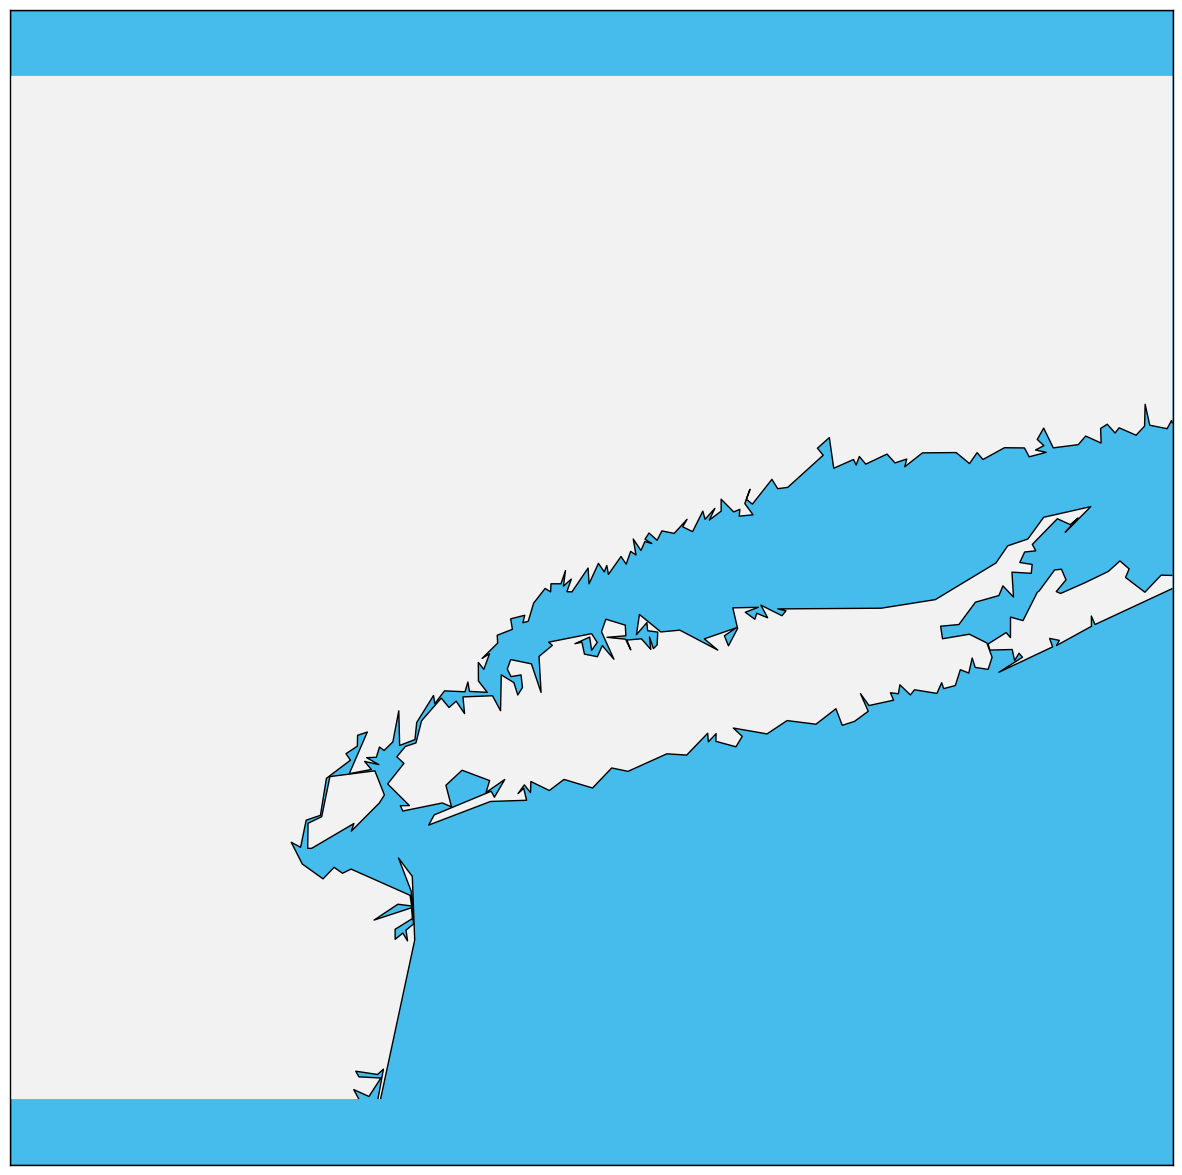

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
m = Basemap(llcrnrlon=LEFT_LOWER_BOUND[0], llcrnrlat=LEFT_LOWER_BOUND[1],
            urcrnrlon=RIGHT_UPPE_BOUND[0], urcrnrlat=RIGHT_UPPE_BOUND[1],
            resolution='i',
            projection='tmerc',
            lon_0=np.mean([LEFT_LOWER_BOUND[0], RIGHT_UPPE_BOUND[0]]), lat_0=41)

ax.set_adjustable('datalim')
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
m.drawcoastlines()
plt.savefig('nyc_map.png', bbox_inches='tight', pad_inches=0)

In [26]:
nyc_map = plt.imread('nyc_map.png')[:,:,0] > 0.5

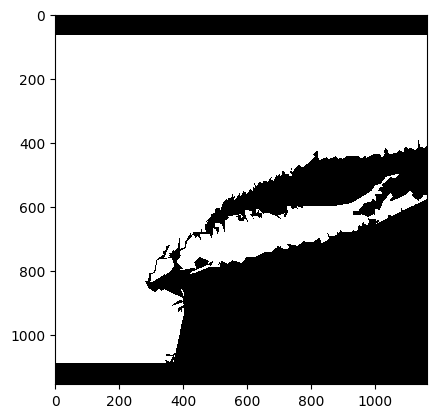

In [27]:
plt.imshow(nyc_map, cmap='gray', interpolation='nearest')

In [28]:
LEFT_LOWER_BOUND = (-75, 40)
RIGHT_UPPE_BOUND = (-72, 42)

In [29]:
def lonlat_to_xy(longitude, latitude, dx, dy):
    return (dx * (longitude - LEFT_LOWER_BOUND[0]) / (RIGHT_UPPE_BOUND[1] - LEFT_LOWER_BOUND[0])).astype('int'), \
           (dy - dy * (latitude - LEFT_LOWER_BOUND[1]) / (RIGHT_UPPE_BOUND[1] - LEFT_LOWER_BOUND[1])).astype('int')

In [30]:
pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                  nyc_map.shape[1], nyc_map.shape[0])
dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                  nyc_map.shape[1], nyc_map.shape[0])

In [31]:
def remove_datapoints_from_water(df):
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_map.shape[1], nyc_map.shape[0])
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_map.shape[1], nyc_map.shape[0])    
    # calculate boolean index
    idx = nyc_map[pickup_y, pickup_x] & nyc_map[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

# meteo data

In [32]:
from meteostat import Point, Daily
from datetime import datetime

location = Point(*CENTER)

start = datetime(2009, 1, 1)
end = datetime(2016, 1, 1)

meteo_data = Daily(location, start, end)
meteo_data = meteo_data.fetch()

meteo_data = meteo_data.reset_index()

In [33]:
meteo_data = meteo_data[['time', 'tmin', 'tmax', 'prcp', 'snow']]
meteo_data['time'] = meteo_data['time'].dt.date
meteo_data.head()

,time,tmin,tmax,prcp,snow
0,2009-01-01,-8.9,-2.2,0.0,0.0
1,2009-01-02,-5.0,2.8,0.0,0.0
2,2009-01-03,-1.1,5.0,0.0,0.0
3,2009-01-04,-3.3,6.7,0.0,0.0
4,2009-01-05,2.8,7.2,0.3,0.0


## common preprocessing

In [34]:
def preprocess(df, is_train=True):
    if is_train:
        df = df[
        (df['pickup_longitude'] < -70) & (df['pickup_longitude'] > -75) & 
        (df['pickup_latitude'] < 42) & (df['pickup_latitude'] > 40) &
        (df['dropoff_longitude'] < -70) & (df['dropoff_longitude'] > -75) & 
        (df['dropoff_latitude'] < 42) & (df['dropoff_latitude'] > 40)
        ]
        df = df[df.fare_amount.between(0, 60)]
        
        df = df[(df['passenger_count'] >= 0) & (df['passenger_count'] <= 6)]

        df = remove_datapoints_from_water(df)

    # считаем значение новой фичи
    df['distance'] = df.progress_apply(lambda x: geodistance(x['pickup_longitude'], x['dropoff_longitude'], 
                                                    x['pickup_latitude'], x['dropoff_latitude']), axis=1)
    
    # df['distance'] = df.progress_apply(lambda x: geodesic((x['pickup_latitude'], 
    #                                                    x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).km, axis=1)

    df['pick_up_distance_from_center'] = df.progress_apply(lambda x: geodistance(x['pickup_longitude'], CENTER[0],
                                                                        x['pickup_latitude'], CENTER[1]), axis=1)
    
    df['drop_off_distance_from_center'] = df.progress_apply(lambda x: geodistance(x['dropoff_longitude'], CENTER[0],
                                                                        x['dropoff_latitude'], CENTER[1]), axis=1)
    
    # df['pick_up_distance_from_center'] = df.progress_apply(lambda x: geodesic((x['pickup_latitude'], 
    #                                                    x['pickup_longitude']), (CENTER)).km, axis=1)
    # df['drop_off_distance_from_center'] = df.progress_apply(lambda x: geodesic((x['dropoff_latitude'], 
    #                                                    x['dropoff_longitude']), (CENTER)).km, axis=1)
    
    df['latitude_abs'] = (df.pickup_latitude - df.dropoff_latitude).abs()
    df['longitude_abs'] = (df.pickup_longitude - df.dropoff_longitude).abs()

    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    df['is_weekend'] = df['pickup_datetime'].progress_apply(lambda x: x.date() in weekends)
    df['is_holiday'] = df['pickup_datetime'].progress_apply(lambda x: True if x.date() in holidays else False)

    df['year'] = df.pickup_datetime.dt.year.astype('uint16')
    df['month'] = df.pickup_datetime.dt.month.astype('uint8')
    df['day'] = df.pickup_datetime.dt.day.astype('uint8')
    df['dayofweek'] = df.pickup_datetime.dt.dayofweek.astype('uint8')

    df['sin_dayofweek'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)

    df['hour'] = df['pickup_datetime'].progress_apply(lambda x: np.sin(2 * np.pi * x.hour / 24))
    df['is_rush_hour'] = df['pickup_datetime'].dt.hour.between(8, 9) | df['pickup_datetime'].dt.hour.between(16, 19)
    df['pickup_cluster'] = kmeans_pick.predict(df[['pickup_latitude', 'pickup_longitude']])
    df['dropoff_cluster'] = kmeans_drop.predict(df[['dropoff_latitude', 'dropoff_longitude']])
    
    df['date'] = df['pickup_datetime'].dt.date
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    df['date'] = df['pickup_datetime'].dt.date
    df = df.merge(meteo_data, left_on='date', right_on='time', how='left')

    if is_train:
        df['fare_amount_adjusted'] = df.progress_apply(lambda x: inflation[x['pickup_datetime'].year] * x['fare_amount'], axis=1)
    return df

In [35]:
df = preprocess(df)

100%|██████████| 4919651/4919651 [00:34<00:00, 142523.99it/s]


In [36]:
df.to_csv('df.csv', index=False)

KeyboardInterrupt: 

In [ ]:
df.isnull().sum()

key                              0
fare_amount                      0
pickup_datetime                  0
pickup_longitude                 0
pickup_latitude                  0
dropoff_longitude                0
dropoff_latitude                 0
passenger_count                  0
distance                         0
pick_up_distance_from_center     0
drop_off_distance_from_center    0
latitude_abs                     0
longitude_abs                    0
is_weekend                       0
is_holiday                       0
year                             0
month                            0
day                              0
dayofweek                        0
sin_dayofweek                    0
sin_month                        0
hour                             0
is_rush_hour                     0
pickup_cluster                   0
dropoff_cluster                  0
date                             0
time                             0
tmin                             0
tmax                

In [ ]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,...,is_rush_hour,pickup_cluster,dropoff_cluster,date,time,tmin,tmax,prcp,snow,fare_amount_adjusted
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,10796.271,13240.194,...,True,0,0,2009-06-15,2009-06-15,13.9,20.0,5.3,0.0,4.5000
1,2009-08-06 18:17:23.0000001,4.5,2009-08-06 18:17:23+00:00,-73.991707,40.770505,-73.985459,40.763671,1,10592.300,13088.624,...,True,0,0,2009-08-06,2009-08-06,19.4,24.4,1.0,0.0,4.5000
2,2011-09-07 14:05:00.000000194,5.7,2011-09-07 14:05:00+00:00,-73.976162,40.744988,-73.990002,40.738323,2,10621.885,13101.155,...,False,0,0,2011-09-07,2011-09-07,17.2,22.2,20.8,0.0,5.4378
3,2011-03-04 18:12:00.000000250,5.3,2011-03-04 18:12:00+00:00,-73.997037,40.737095,-73.986128,40.735043,1,10590.385,13079.805,...,True,0,0,2011-03-04,2011-03-04,-4.4,5.0,0.0,0.0,5.0562
4,2012-01-04 18:07:29.0000002,15.3,2012-01-04 18:07:29+00:00,-73.971510,40.755886,-73.968067,40.801173,1,10620.579,13106.980,...,True,0,0,2012-01-04,2012-01-04,-10.6,-1.7,0.0,0.0,14.2902


# графики

In [ ]:
sns.relplot(data=df, x='distance', y='fare_amount_adjusted')

Error in callback <function flush_figures at 0x00000224BA0272E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

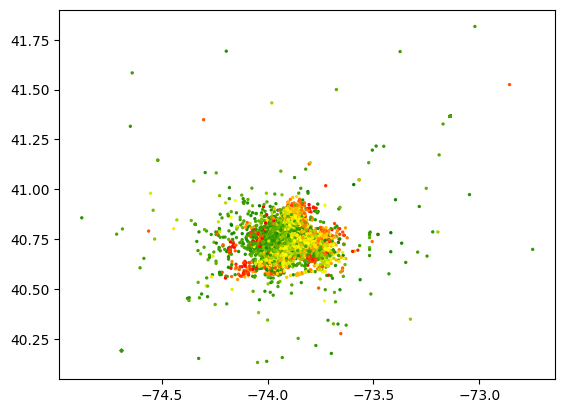

In [ ]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


quantiles = np.percentile(df['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['fare_amount'],
                    s=2, cmap=cmap, norm=norm)

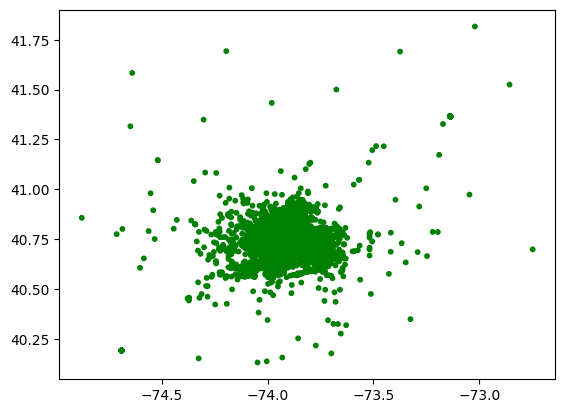

In [ ]:
cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['pickup_cluster'],
                    s=10, cmap=cmap, norm=norm)

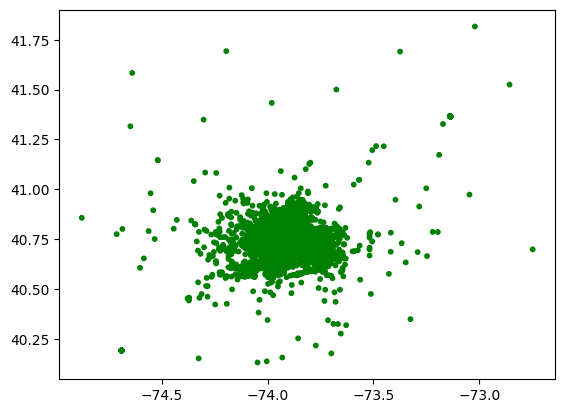

In [ ]:
cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['dropoff_cluster'],
                    s=10, cmap=cmap, norm=norm)

<Axes: >

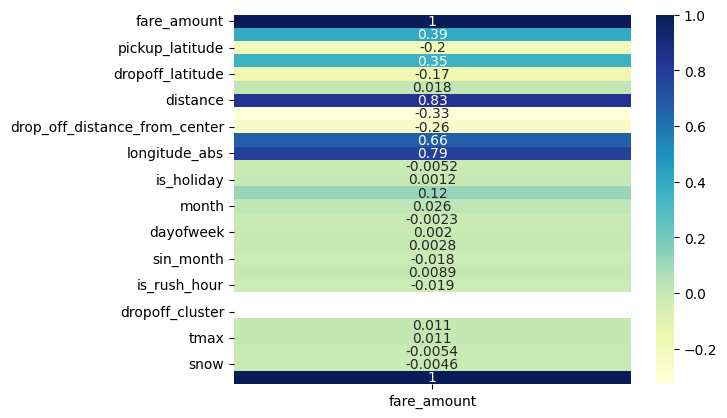

In [ ]:
sns.heatmap(df.corr(numeric_only=True)[['fare_amount']], cmap="YlGnBu", annot=True)

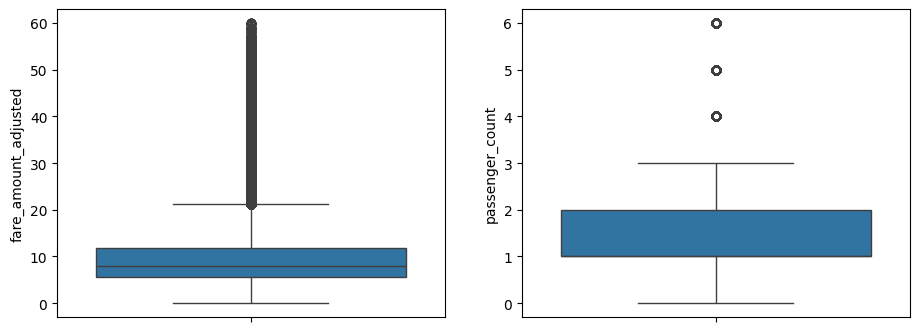

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))


sns.boxplot(df['fare_amount_adjusted'], ax=axes[0])
sns.boxplot(df['passenger_count'], ax=axes[1])
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

The palette list has fewer values (10) than needed (24) and will cycle, which may produce an uninterpretable plot.


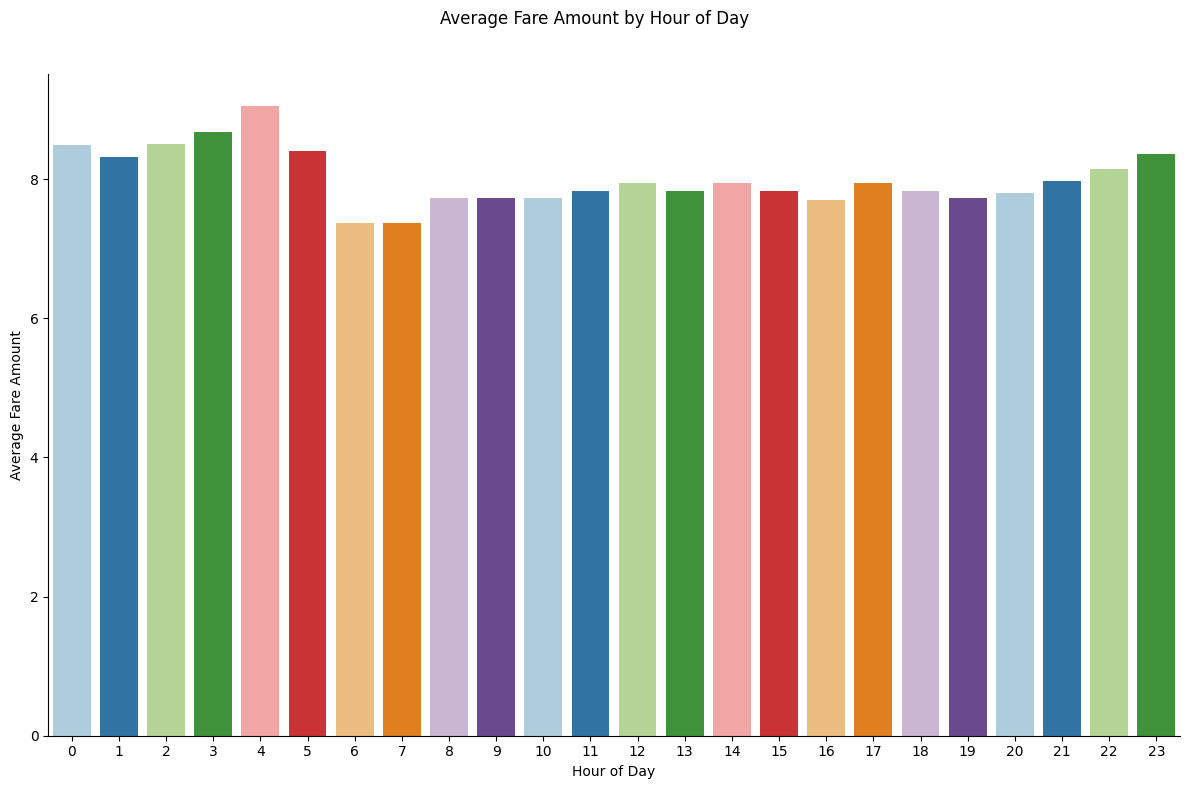

In [ ]:
palette = sns.color_palette('Paired', 10)

# Создаем новый датафрейм со средней стоимостью поездки по каждому часу
df['hour2'] = df.pickup_datetime.dt.hour.astype('uint16')
hourly_fares = df.groupby('hour2', as_index=False).agg({'fare_amount_adjusted': 'median'})

# Построение графика
sns.catplot(x="hour2", y="fare_amount_adjusted", kind="bar", palette=palette, data=hourly_fares, height=8, aspect=1.5)
sns.despine()

# Установка заголовка и подписей осей
plt.subplots_adjust(top=0.9)  # Оставляем место для заголовка
plt.suptitle('Average Fare Amount by Hour of Day')  # Заголовок всего графика
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare Amount")

plt.show()
df = df.drop(columns=['hour2'])

# fitting

In [37]:
to_drop = ['key', 'fare_amount', 'fare_amount_adjusted', 'pickup_datetime', 'date', 'time']

X = df.drop(to_drop, axis=1)
y = df['fare_amount_adjusted']

In [38]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,drop_off_distance_from_center,latitude_abs,longitude_abs,...,sin_dayofweek,sin_month,hour,is_rush_hour,pickup_cluster,dropoff_cluster,tmin,tmax,prcp,snow
0,-73.844311,40.721319,-73.841610,40.712278,1,1.031,15076.555,15075.535,0.009041,0.002701,...,0.000000,1.224647e-16,-0.965926,True,0,0,13.9,20.0,5.3,0.0
1,-73.991707,40.770505,-73.985459,40.763671,1,0.924,15086.155,15085.256,0.006834,0.006248,...,0.433884,-8.660254e-01,-1.000000,True,0,0,19.4,24.4,1.0,0.0
2,-73.976162,40.744988,-73.990002,40.738323,2,1.382,15083.036,15082.768,0.006665,0.013840,...,0.974928,-1.000000e+00,-0.500000,False,0,0,17.2,22.2,20.8,0.0
3,-73.997037,40.737095,-73.986128,40.735043,1,0.947,15082.856,15082.310,0.002052,0.010909,...,-0.433884,1.000000e+00,-1.000000,True,0,0,-4.4,5.0,0.0,0.0
4,-73.971510,40.755886,-73.968067,40.801173,1,5.044,15084.023,15088.611,0.045287,0.003443,...,0.974928,5.000000e-01,-1.000000,True,0,0,-10.6,-1.7,0.0,0.0


In [39]:
import math


df.head(1).progress_apply(lambda x: geodesic((x['pickup_latitude'], 
                                             x['pickup_longitude']), 
                                             CENTER).km / 111, axis=1)

100%|██████████| 1/1 [00:00<00:00, 992.50it/s]


0    0.03991
dtype: float64

In [40]:
df.head(1).progress_apply(lambda x: geodistance(x['dropoff_longitude'], CENTER[0],
                                                                        x['dropoff_latitude'], CENTER[1]), axis=1)

100%|██████████| 1/1 [00:00<00:00, 938.74it/s]


0    15075.535
dtype: float64

In [41]:
X

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,drop_off_distance_from_center,latitude_abs,longitude_abs,...,sin_dayofweek,sin_month,hour,is_rush_hour,pickup_cluster,dropoff_cluster,tmin,tmax,prcp,snow
0,-73.844311,40.721319,-73.841610,40.712278,1,1.031,15076.555,15075.535,0.009041,0.002701,...,0.000000,1.224647e-16,-0.965926,True,0,0,13.9,20.0,5.3,0.0
1,-73.991707,40.770505,-73.985459,40.763671,1,0.924,15086.155,15085.256,0.006834,0.006248,...,0.433884,-8.660254e-01,-1.000000,True,0,0,19.4,24.4,1.0,0.0
2,-73.976162,40.744988,-73.990002,40.738323,2,1.382,15083.036,15082.768,0.006665,0.013840,...,0.974928,-1.000000e+00,-0.500000,False,0,0,17.2,22.2,20.8,0.0
3,-73.997037,40.737095,-73.986128,40.735043,1,0.947,15082.856,15082.310,0.002052,0.010909,...,-0.433884,1.000000e+00,-1.000000,True,0,0,-4.4,5.0,0.0,0.0
4,-73.971510,40.755886,-73.968067,40.801173,1,5.044,15084.023,15088.611,0.045287,0.003443,...,0.974928,5.000000e-01,-1.000000,True,0,0,-10.6,-1.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4919646,-73.997682,40.724382,-73.994150,40.717797,1,0.790,15081.558,15080.768,0.006585,0.003532,...,-0.974928,-8.660254e-01,0.965926,False,0,0,13.9,22.2,0.0,0.0
4919647,-73.955734,40.768257,-73.947820,40.782169,1,1.684,15084.823,15086.023,0.013912,0.007914,...,-0.974928,-5.000000e-01,0.500000,False,0,0,11.7,19.4,0.0,0.0
4919648,-73.970862,40.752003,-73.977449,40.742823,1,1.162,15083.601,15082.851,0.009180,0.006587,...,-0.974928,-8.660254e-01,-0.500000,False,0,0,2.8,12.8,0.0,0.0
4919649,-73.989768,40.739100,-73.986871,40.751651,1,1.417,15082.842,15084.054,0.012551,0.002897,...,-0.433884,5.000000e-01,0.965926,False,0,0,11.1,20.6,0.3,0.0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=2024)

# model = CatBoostRegressor(iterations=1000,
#                           depth=3,
#                           learning_rate=0.01,
#                           eval_metric='RMSE',
#                           use_best_model=True,
#                           verbose=100)

model = CatBoostRegressor(iterations=500,
                          use_best_model=True,
                          verbose=100)

In [45]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.294293
0:	learn: 6.4819811	test: 6.5598596	best: 6.5598596 (0)	total: 239ms	remaining: 1m 59s
100:	learn: 3.0408330	test: 3.0890916	best: 3.0890916 (100)	total: 23.1s	remaining: 1m 31s
200:	learn: 2.9669325	test: 3.0151298	best: 3.0151298 (200)	total: 46s	remaining: 1m 8s
300:	learn: 2.9273720	test: 2.9769835	best: 2.9769835 (300)	total: 1m 8s	remaining: 45.3s
400:	learn: 2.9038231	test: 2.9563840	best: 2.9563840 (400)	total: 1m 31s	remaining: 22.5s
499:	learn: 2.8859098	test: 2.9409267	best: 2.9408724 (498)	total: 1m 52s	remaining: 0us

bestTest = 2.940872374
bestIteration = 498

Shrink model to first 499 iterations.


In [60]:
from sklearn.metrics import root_mean_squared_error

In [61]:
len(model.predict(df[X.columns]))

4919651

In [62]:
root_mean_squared_error(np.array(df['fare_amount']), model.predict(df[X.columns]))

3.199355503171478

# Inferring

In [63]:
pd.read_csv(r'data/sample_submission.csv').head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [64]:
test = pd.read_csv(r'data/test.csv')

In [65]:
test = preprocess(test, is_train=False)

100%|██████████| 9914/9914 [00:00<00:00, 318360.43it/s]


In [66]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,drop_off_distance_from_center,...,hour,is_rush_hour,pickup_cluster,dropoff_cluster,date,time,tmin,tmax,prcp,snow
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.323,15084.899,15083.078,...,-0.258819,False,0,0,2015-01-27,2015-01-27,-6.6,-2.7,7.9,230.0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.425,15080.710,15083.131,...,-0.258819,False,0,0,2015-01-27,2015-01-27,-6.6,-2.7,7.9,230.0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.619,15083.881,15083.262,...,0.258819,False,0,0,2011-10-08,2011-10-08,12.2,24.4,0.0,0.0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.961,15085.553,15084.161,...,-0.707107,False,0,0,2012-12-01,2012-12-01,3.9,7.2,0.0,0.0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,5.387,15087.368,15083.357,...,-0.707107,False,0,0,2012-12-01,2012-12-01,3.9,7.2,0.0,0.0


In [67]:
test[X.columns].head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,drop_off_distance_from_center,latitude_abs,longitude_abs,...,sin_dayofweek,sin_month,hour,is_rush_hour,pickup_cluster,dropoff_cluster,tmin,tmax,prcp,snow
0,-73.973320,40.763805,-73.981430,40.743835,1,2.323,15084.899,15083.078,0.019970,0.008110,...,0.781831,5.000000e-01,-0.258819,False,0,0,-6.6,-2.7,7.9,230.0
1,-73.986862,40.719383,-73.998886,40.739201,1,2.425,15080.710,15083.131,0.019817,0.012024,...,0.781831,5.000000e-01,-0.258819,False,0,0,-6.6,-2.7,7.9,230.0
2,-73.982524,40.751260,-73.979654,40.746139,1,0.619,15083.881,15083.262,0.005121,0.002870,...,-0.974928,-8.660254e-01,0.258819,False,0,0,12.2,24.4,0.0,0.0
3,-73.981160,40.767807,-73.990448,40.751635,1,1.961,15085.553,15084.161,0.016172,0.009288,...,-0.974928,-2.449294e-16,-0.707107,False,0,0,3.9,7.2,0.0,0.0
4,-73.966046,40.789775,-73.988565,40.744427,1,5.387,15087.368,15083.357,0.045348,0.022519,...,-0.974928,-2.449294e-16,-0.707107,False,0,0,3.9,7.2,0.0,0.0


In [68]:
test['fare_amount'] = model.predict(test[X.columns])

In [69]:
test['fare_amount'] = test.apply(lambda x: x['fare_amount'] / inflation[x['pickup_datetime'].year], axis=1)

In [70]:
test[['key', 'fare_amount']].to_csv('sub2.csv', index=False)

In [71]:
test[['key', 'fare_amount']]

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.183605
1,2015-01-27 13:08:24.0000003,9.081206
2,2011-10-08 11:53:44.0000002,4.154516
3,2012-12-01 21:12:12.0000002,9.281633
4,2012-12-01 21:12:12.0000003,16.168211
...,...,...
9909,2015-05-10 12:37:51.0000002,8.807182
9910,2015-01-12 17:05:51.0000001,10.912352
9911,2015-04-19 20:44:15.0000001,54.063282
9912,2015-01-31 01:05:19.0000005,21.154640


In [72]:
pd.DataFrame({
    'columns': X.columns,
    'importances': model.feature_importances_}
    )

,columns,importances
0,pickup_longitude,4.102180
1,pickup_latitude,1.861020
2,dropoff_longitude,5.456650
3,dropoff_latitude,2.536585
4,passenger_count,0.100205
5,distance,49.374419
6,pick_up_distance_from_center,2.272621
7,drop_off_distance_from_center,6.270121
8,latitude_abs,3.015162
9,longitude_abs,13.695037


NameError: name 'norm' is not defined

<Figure size 1000x1000 with 0 Axes>

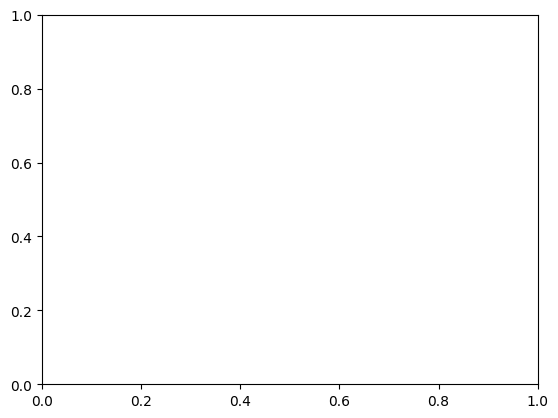

In [73]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


# quantiles = np.percentile(test['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
# norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(test['dropoff_longitude'], test['dropoff_latitude'], c=test['dropoff_cluster'],
                    s=10, cmap=cmap, norm=norm)

<Figure size 1000x1000 with 0 Axes>

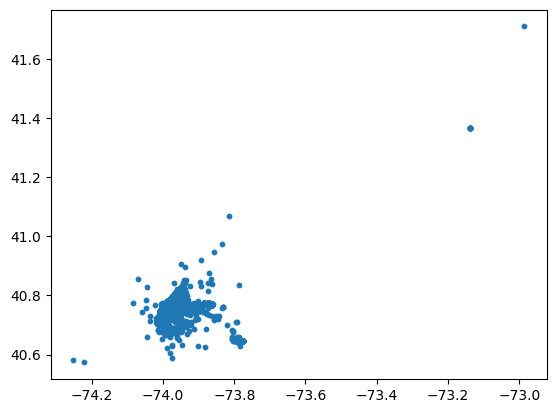

In [ ]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


# quantiles = np.percentile(test['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
# norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(test['pickup_longitude'], test['pickup_latitude'],
                    s=10, cmap=cmap, norm=norm)

In [ ]:
data.sample(200_000).to_csv('data.csv', index=False)